In [1]:
# import libraries
import threading
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import datetime
from concurrent.futures import ThreadPoolExecutor
import sys
from onnxruntime import InferenceSession, SessionOptions, GraphOptimizationLevel
import torch
from collections import deque, Counter

In [2]:
# import models
from models.tools import wait_process, disp_historicalgraph
from models import signalprocessing as sp
from models import measurement_BNO055
from controller.viewcontrol import measurement_controller

In [3]:
        
def lay(width,height):
    return widgets.Layout(width=str(width)+"px",height=str(height)+"px")
def init_meas_system():
    meas_ctrl = measurement_controller(BNO_UPDATE_FREQUENCY_HZ=10, seq_len=1000, Isautosave=False)
    display(widgets.VBox([
            widgets.HBox([meas_ctrl.ctrl_button, meas_ctrl.save_button, meas_ctrl.calib_button, ]), 
            meas_ctrl.output]))


    return meas_ctrl
def main_loop():
    meas_ctrl = init_meas_system()
    meas_ctrl.Run()
    return meas_ctrl

In [4]:
meas_ctrl = main_loop()

Measurement will be Started...
Measurement is started
Finish
Dataframe was saved!


In [8]:
options = SessionOptions()
options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
session = InferenceSession('./data/prod_ONNX.onnx',
                           sess_options=options,
                           provider=['CUDAExecutionProvider', 'CPUExecutionProvider'])

In [12]:
pred_label_queue = deque()
try:
    while True:
        wait_process(10)
        input = np.concatenate([np.array(meas_ctrl.measurement.linear_accel_x_queue), 
                            np.array(meas_ctrl.measurement.linear_accel_y_queue),
                            np.array(meas_ctrl.measurement.gyro_x_queue),
                            np.array(meas_ctrl.measurement.gyro_y_queue),
                            np.array(meas_ctrl.measurement.gyro_z_queue),
                            np.array(meas_ctrl.measurement.gyro_x_queue)], axis=0).reshape(100,-1)
        input_Tensor = torch.tensor(input, dtype=torch.float32)
        input_Tensor = input_Tensor.reshape(1, 100, -1)
        y = session.run(None, {'input':np.array(input_Tensor.to('cpu'))})
        pred_label_val = y[0].argmax(1)
        pred_label_queue.append(pred_label_val[-1])

        final_pred_label = Counter(pred_label_queue).most_common()[0][0]
        print("Recent prediction result is : {0}".format(pred_label_val))
        print("Final prediction result is : {0}".format(final_pred_label))

except KeyboardInterrupt:
    print("KeyboardInterrupt")
    



Recent prediction result is : [4]
Final prediction result is : 4
KeyboardInterrupt


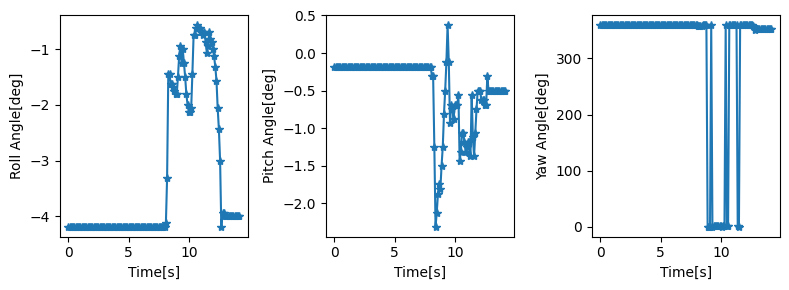

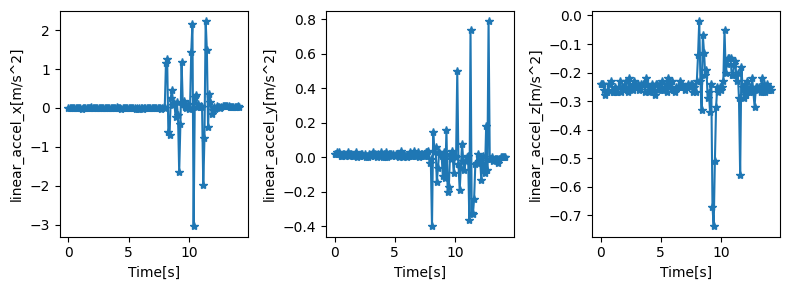

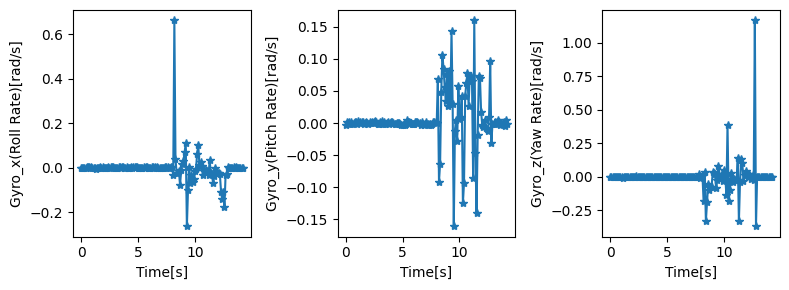

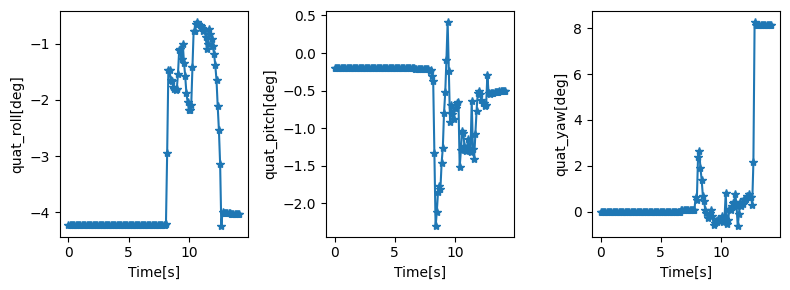

In [5]:
disp_historicalgraph(meas_ctrl.measurement.df, mode="euler")
disp_historicalgraph(meas_ctrl.measurement.df, mode="linear_accel")
disp_historicalgraph(meas_ctrl.measurement.df, mode="gyro")
disp_historicalgraph(meas_ctrl.measurement.df, mode="quat_angle")